In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import commot as ct
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adata = sc.read_h5ad("Visium_IRI_R.h5ad")

In [3]:
adata.X = adata.raw.X
adata.var_names_make_unique()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [ ]:
df_ligrec = ct.pp.ligand_receptor_database(database='CellChat', species='mouse', signaling_type=None)
print(df_ligrec.shape)
df_cellchat_filtered = ct.pp.filter_lr_database(df_ligrec, adata, min_cell_pct=0.01)
print(df_cellchat_filtered.shape)

In [ ]:
df_ligrec.columns = ['Ligand', 'Receptor', 'Pathway', 'Category']

In [6]:
def expand_interactions(row):
    ligands = row['Ligand'].split('_')
    receptors = row['Receptor'].split('_')
    interactions = [{'Ligand': ligand, 'Receptor': receptor, 'Pathway': row['Pathway'], 'Category': row['Category']}
                    for ligand in ligands for receptor in receptors]
    return pd.DataFrame(interactions)

expanded_df = pd.concat([expand_interactions(row) for _, row in df_ligrec.iterrows()], ignore_index=True)

In [48]:
expanded_df.to_csv("CellChat_db.csv") ## Both Visium and imputed Xenium are using same LR database.

In [7]:
## convert the visium coordinates to Xenium coordinates (um)
adata.obsm['spatial'] = adata.obs[['x_align', 'y_align']].values

In [11]:
idents = ['ShamR', 'Hour4R', 'Hour12R', 'Day2R', 'Day14R', 'Week6R']
ad_list = {}
for i in idents:
    print(i)
    ad = adata[adata.obs.ident == i].copy()
    ct.tl.spatial_communication(ad, database_name='cellchat', df_ligrec=df_ligrec, dis_thr=100, 
                            heteromeric=True, pathway_sum=True)
    ad_list[i] = ad

ShamR
Hour4R
Hour12R
Day2R
Day14R
Week6R


In [17]:
signal_sender = []
signal_receiver = []
for i in idents:
    signal_sender.append(ad_list[i].obsm['commot-cellchat-sum-sender'])
    signal_receiver.append(ad_list[i].obsm['commot-cellchat-sum-receiver'])

In [18]:
signal_sender_df = pd.concat(signal_sender)
signal_receiver_df = pd.concat(signal_receiver)

In [7]:
signal_sender_df = signal_sender_df.drop(columns = 's-total-total')
signal_receiver_df = signal_receiver_df.drop(columns = 'r-total-total')

In [8]:
adata.obsm['commot-cellchat-sum-sender'] = signal_sender_df
adata.obsm['commot-cellchat-sum-receiver'] = signal_receiver_df

In [9]:
counts_df = adata.obs.groupby(['assigned_cn_label','ident']).size().reset_index(name = 'counts')
valid = counts_df[counts_df['counts'] >=20]
keep_conditions = set(zip(valid['ident'], valid['assigned_cn_label']))
mask = adata.obs.apply(lambda row: (row['ident'], row['assigned_cn_label']) in keep_conditions, axis=1)

/tmp/ipykernel_4046448/3394135691.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_df = adata.obs.groupby(['assigned_cn_label','ident']).size().reset_index(name = 'counts')


In [10]:
print(adata.shape)
adata_filtered = adata[mask]
print(adata_filtered.shape)

(9259, 19465)
(9204, 19465)


In [11]:
X_r = adata_filtered.obsm['commot-cellchat-sum-receiver'].values
colname_r = list(adata_filtered.obsm['commot-cellchat-sum-receiver'].columns.values )
X_s = adata_filtered.obsm['commot-cellchat-sum-sender'].values
colname_s = list(adata_filtered.obsm['commot-cellchat-sum-sender'].columns.values )
X_signal = np.concatenate( (X_r, X_s), axis=1 )
colname = colname_r + colname_s
import anndata
adata_signal = anndata.AnnData(X=X_signal, var=pd.DataFrame(index=colname))

In [12]:
adata_signal.obs["CN"] = np.array(adata_filtered.obs['assigned_cn_label'])
adata_signal.obs['ident'] = adata_filtered.obs['ident'].values

In [95]:
pathways = np.unique(df_ligrec.loc[:,'Pathway'])

In [96]:
pathways

array(['ACTIVIN', 'ADGRE5', 'ADIPONECTIN', 'AGRN', 'AGT', 'ALCAM', 'AMH',
       'ANGPT', 'ANGPTL', 'ANNEXIN', 'ANXA1', 'APELIN', 'APJ', 'APP',
       'APRIL', 'AVP', 'BAFF', 'BAG', 'BMP', 'BMP10', 'BRADYKININ', 'BSP',
       'BST2', 'BTLA', 'CADM', 'CALCR', 'CCK', 'CCL', 'CD137', 'CD1D2',
       'CD200', 'CD22', 'CD226', 'CD23', 'CD30', 'CD34', 'CD39', 'CD40',
       'CD45', 'CD46', 'CD48', 'CD52', 'CD6', 'CD70', 'CD80', 'CD86',
       'CD96', 'CD99', 'CDH', 'CDH1', 'CDH5', 'CEACAM', 'CHAD',
       'CHEMERIN', 'CLDN', 'CLEC', 'CNTN', 'COLLAGEN', 'COMPLEMENT',
       'CRH', 'CSF', 'CSF3', 'CSPG4', 'CX3C', 'CXCL', 'DESMOSOME', 'DMP1',
       'DSPP', 'EDA', 'EDN', 'EGF', 'ENHO', 'EPGN', 'EPHA', 'EPHB', 'EPO',
       'ESAM', 'FASLG', 'FGF', 'FLT3', 'FN1', 'FSH', 'GALANIN',
       'GALECTIN', 'GAS', 'GCG', 'GDF', 'GDNF', 'GH', 'GHRELIN', 'GHRH',
       'GIPR', 'GITRL', 'GNRH', 'GP1BA', 'GPR', 'GRN', 'GUCA', 'HCRT',
       'HGF', 'HH', 'HSPG', 'ICAM', 'ICOS', 'IFN-I', 'IFN-II', 'IFN-lII',
 

In [97]:
pathway_adata = adata_signal[:,adata_signal.var_names.str.contains('|'.join(pathways))].copy()
pathway_adata = pathway_adata[:,pathway_adata.var_names.str.contains('r-')]
sc.tl.rank_genes_groups(pathway_adata, 'CN', method='wilcoxon', key_added="rank_CN_pathway")
ranked_genes_df = sc.get.rank_genes_groups_df(pathway_adata, group=None, key="rank_CN_pathway")

In [23]:
bar_df = ranked_genes_df[(ranked_genes_df['group']=='CN7') & (ranked_genes_df['scores']>10)].sort_values("logfoldchanges", ascending=False)
bar_df['Pathway'] = bar_df['names'].str.split('-').str[1]
bar_df = bar_df.head(25)

In [422]:
fc = list(bar_df['logfoldchanges'])
terms = list(bar_df['Pathway'])

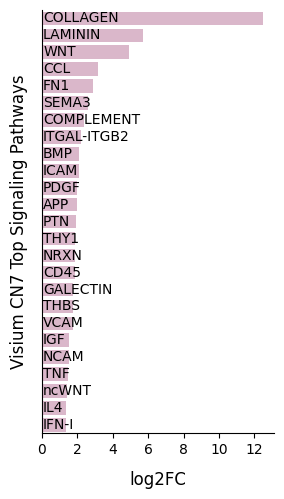

In [423]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(3,5.5), dpi = 100)
    
fig = sns.barplot(x=fc, y=terms, color="#E0B1CB", edgecolor=None, linewidth=0)
fig.set_xlabel('log2FC', fontsize=12, labelpad=10)
fig.set_ylabel('Visium CN7 Top Signaling Pathways', fontsize=12, labelpad=10)
fig.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tick_params(axis='x', which='major', labelsize=10)
fig.set_yticks([])
fig.tick_params(axis='y', which='both', length=0)
fig.yaxis.label.set_visible(True)

for ii, annot in enumerate(terms):
        
    title_start= max(fig.axes.get_xlim())/200
    import textwrap
    lines = textwrap.wrap(annot, width=60)
    for line_number, line in enumerate(lines):
        fig.text(title_start, ii + line_number * 0.5, line, ha='left', va='center', fontsize=10)

fig.spines['right'].set_visible(False)
fig.spines['top'].set_visible(False)
plt.savefig('Visium_signalingPathway.png', bbox_inches='tight', transparent=True, dpi = 300)
plt.show() 

In [47]:
lr_adata = adata_signal[:,~adata_signal.var_names.str.contains('|'.join(pathways))].copy()
lr_adata = lr_adata[:,~lr_adata.var_names.str.contains('s-')].copy()

In [50]:
lr_adata.var_names = lr_adata.var_names.str.split('-', n=1).str[1]

In [42]:
top_lr = ['Wnt7b-Fzd4_Lrp6','Wnt7b-Fzd4_Lrp6','Wnt5a-Fzd4','Wnt5a-Fzd1','Tnn-Itgav_Itgb6','Fgf1-Fgfr2','Hbegf-Erbb4','Angpt2-Tek',
          'Thbs1-Sdc1','Gas6-Mertk','Vegfa-Kdr','Dlk1-Notch4','Vegfa-Flt1_Kdr','Sema3e-Plxnd1',
          'Slurp1-Chrna4','Sema4g-Plxnb2','Sema4a-Timd2','Lama1-Itgav_Itgb8',
          'Cck-Cckar','F2-Pard3',
          'Angptl4-Sdc4','Areg-Egfr','Hbegf-Egfr','Thbs1-Cd36','Il11-Il11ra1_Il6st','Angptl4-Itga5_Itgb1','Spp1-Itga5_Itgb1',
          'Kitl-Kit','Fgf9-Fgfr2','Bmp6-Bmpr1b_Bmpr2','Sema4g-Plxnb2','Lama3-Sv2a','Sema3b-Nrp1_Plxna2',
          'Itgal_Itgb2-Icam1',
          'Mif-Cd74_Cd44','Gas6-Axl','Ccl12-Ccr2','C3-C3ar1','Ccl8-Ccr2','Ccl2-Ccr2','Ccl6-Ccr2','Ncam1-Fgfr1','Pdgfb-Pdgfra','Pdgfa-Pdgfra','Pdgfb-Pdgfra','Igf1-Igf1r','Postn-Itgav_Itgb5','Lgals9-Ptprc','Tgfb2-Tgfbr1_Tgfbr2','Il34-Csf1r','Csf1-Csf1r','Sema3c-Nrp1_Nrp2_Plxnd1','Tnf-Tnfrsf1b','Tnc-Itga9_Itgb1','Cxcl12-Ackr3',
          ] 

In [43]:
top_lr = [lr for lr in top_lr if lr in lr_adata.var_names]
print(len(top_lr))

55


In [51]:
value_mapping = {
    'CN0': 'CN0: Loop of Henle',
    'CN1': 'CN1: Glomerular Niche',
    'CN2': 'CN2: Cortical Proximal Tubule',
    'CN3': 'CN3: Medullary Proximal Tubule',
    'CN4': 'CN4: Injured Proximal Tubule',
    'CN5': 'CN5: Collecting Duct Niche',
    'CN6': 'CN6: Distal Tubule Niche',
    'CN7': 'CN7: Fibro-inflammatory Niche',
    'CN8': 'CN8: Uro-immune Niche'
}
lr_adata.obs['CN'] = lr_adata.obs['CN'].map(value_mapping)

In [53]:
sc.tl.rank_genes_groups(lr_adata, 'CN', method='wilcoxon')

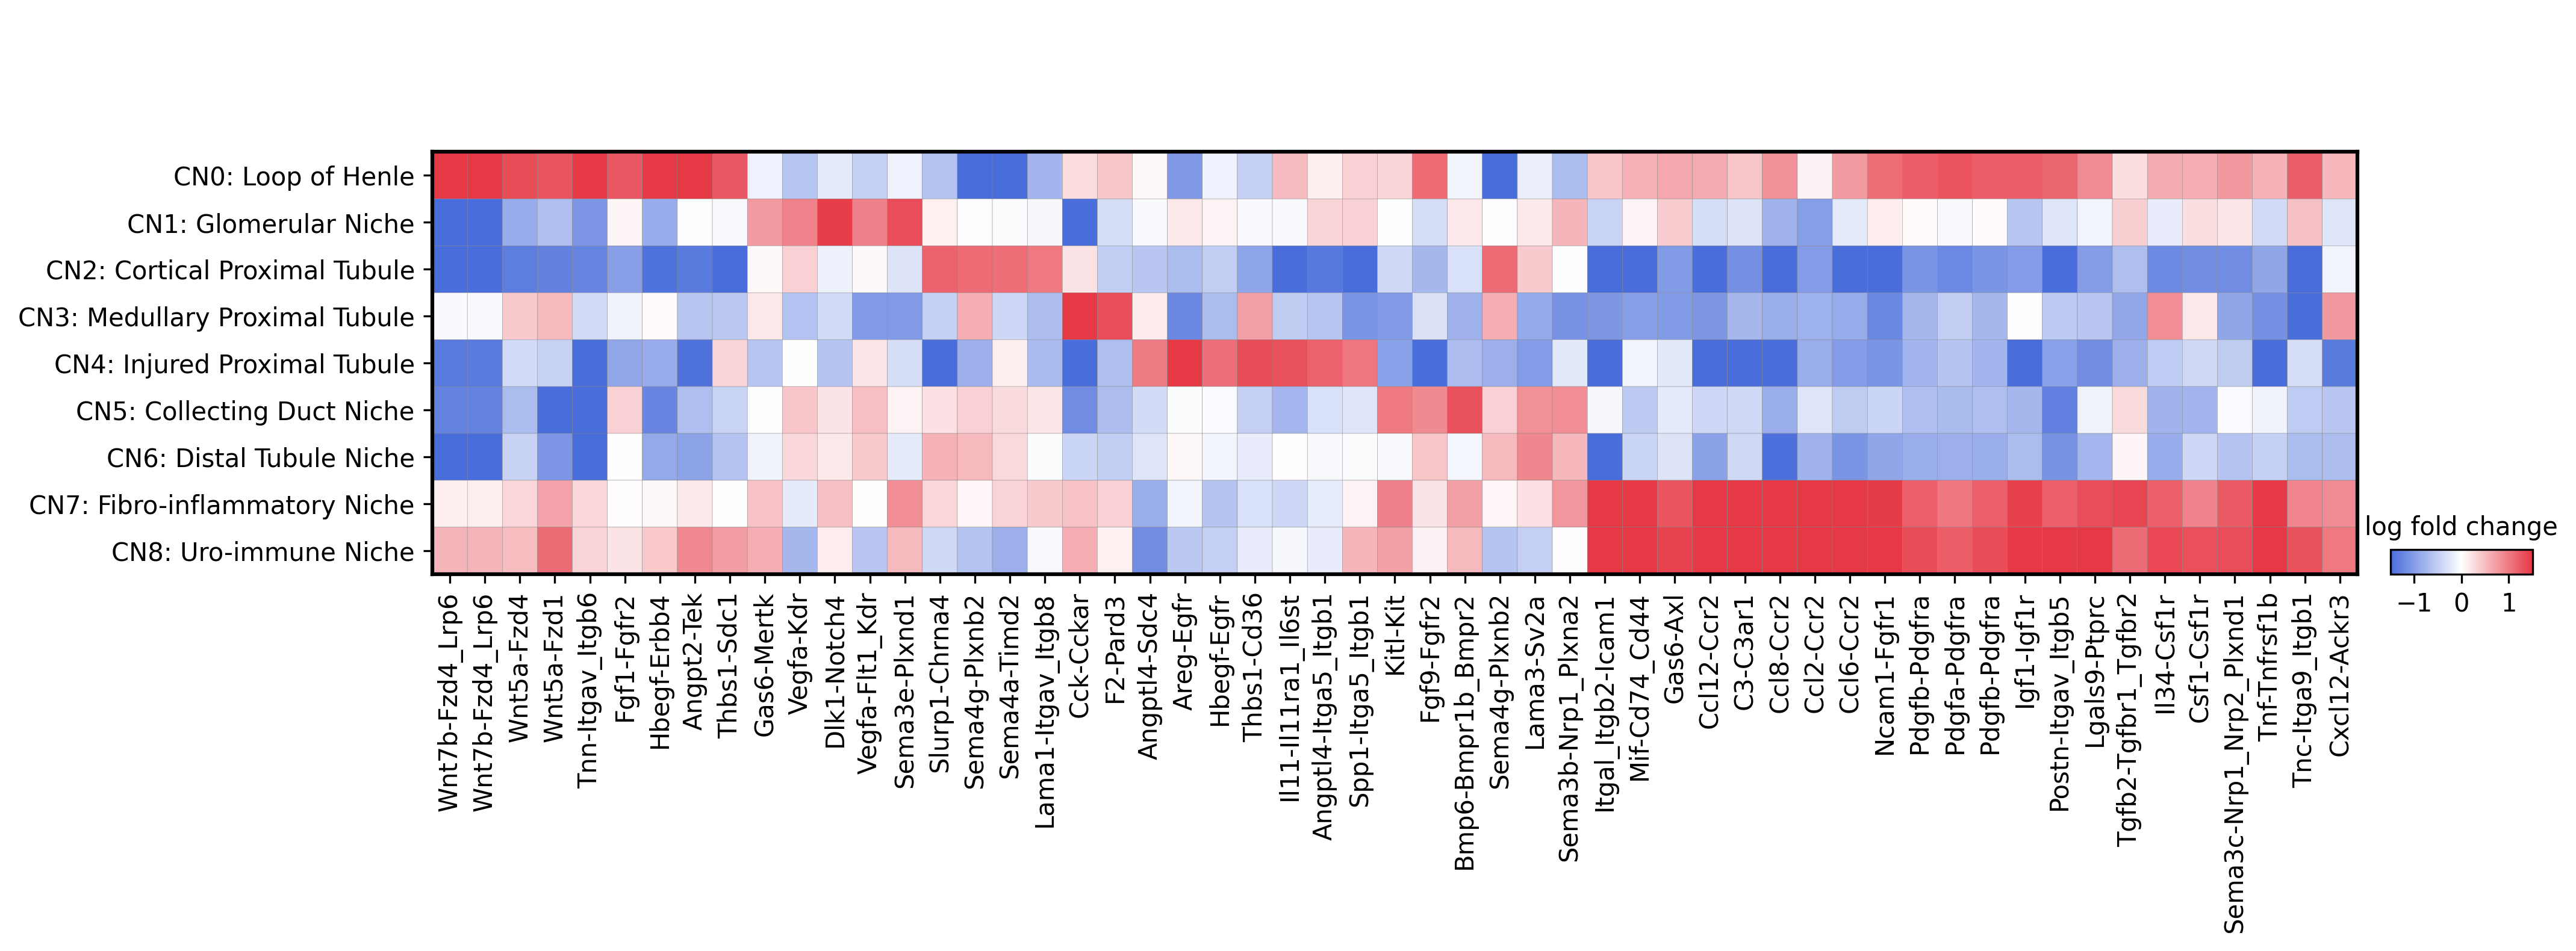

In [54]:
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.rcParams['font.size'] = 12

fig, ax = plt.subplots(figsize = (15,4), dpi = 300)
ax = sc.pl.rank_genes_groups_matrixplot(
    lr_adata,
    values_to_plot="logfoldchanges",
    cmap=mcolors.LinearSegmentedColormap.from_list('Immune', ["#496DDB","#ffffff","#E63946"], N=256),
    vmin= -1.5,
    vmax= 1.5,
    colorbar_title='log fold change',
    groupby='CN',
    ax = ax,
    dendrogram = False,
    var_names=top_lr,
    
)
fig.savefig("Visium_LR_cluster.pdf", bbox_inches = "tight", transparent=True, dpi = 300)
plt.show()

Figure 6 D, E, Supplementary Figure 12

In [ ]:

pathway = ['PDGF']

import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list('WhBu',["#f2f2f2", "#d7bad2", '#b36d98'], N=256) 
cmap = "coolwarm"
all_values = []
for ad in 
.values():
    X_sc = np.array(ad.obs[['x_align', 'y_align']])

    fig, ax = plt.subplots(dpi = 100)
    colors = ad.obsm['commot-cellchat-sum-receiver'][f'r-{pathway}'].values
    all_values.extend(colors)
    vmax = 5.9
    norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)

    idx = np.argsort(colors)
    if ad.obs.ident.unique() in ['ShamR','Day14R']:
        ax.scatter(X_sc[idx,0], X_sc[idx,1], c=colors[idx], cmap=cmap, s=18, vmin=0, vmax=vmax)
    else:
        ax.scatter(X_sc[idx,0], X_sc[idx,1], c=colors[idx], cmap=cmap, s=12, vmin=0, vmax=vmax)
    ax.axis('scaled')
    ax.axis("off")
    plt.savefig(f"figures/{ad.obs.ident.unique()[0]}-r-{pathway}_signal.png", bbox_inches='tight', transparent = True)
    plt.show()

Figure 6 F,G

In [ ]:
ad = ad_list['Day14R']

df_deg, df_yhat = ct.tl.communication_deg_detection(ad,
    database_name = 'cellchat', pathway_name='PDGF', summary = 'receiver')

df_deg_clus, df_yhat_clus = ct.tl.communication_deg_clustering(df_deg.iloc[:,:3], df_yhat, deg_clustering_res=0.01)

interest_genes = ['Col1a1','Col1a2','Col15a1','Gpc6', 'Tpm1',  'Fn1', 'Tnc', 'Cnn2', 'Serpine1','Ccdc80' ]

df_deg_clus_tmp = df_deg_clus.loc[interest_genes]
df_deg_clus_tmp = df_deg_clus.loc[interest_genes]

import seaborn as sns
sns.set(font_scale=1)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('WhBu',['#301927', '#a45585', '#ba7aa1', "#d7bad2", "#f2f2f2"], N=256) 
g = sns.clustermap(df_yhat_clus_tmp, 
    row_cluster=False, 
    col_cluster=False, 
    cmap = 'Reds_r',
    xticklabels = False,
    yticklabels = True,
    linewidths=0)
g.cax.set_position([1.5, .2, .03, .35])
g.fig.set_size_inches(2, 3)
for label in g.ax_heatmap.get_yticklabels():
    label.set_rotation(0)
g.savefig('figures/clustermap_PDGF.pdf', transparent = True, dpi=300)